In [14]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.style.use("seaborn-white")
sns.set_palette("deep")
sns.set_context("paper")
from pathlib import Path
from sec_certs.dataset import CCDataset

RESULTS_DIR = Path("./cc/results")

matplotlib.use("pgf")
sns.set_theme(style='white')
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 0
plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True
plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["axes.labelsize"] = 7
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams['lines.markersize'] = 4
sns.set_palette("deep")

dset = CCDataset.from_json("/Users/adam/phd/projects/certificates/sec-certs/datasets/new_cc/dataset.json")  # local instantiation
df = dset.to_pandas()

In [15]:
df = pd.read_csv(RESULTS_DIR / "exploded_cves.csv").rename(columns={"Unnamed: 0": "dgst"}).set_index("dgst")


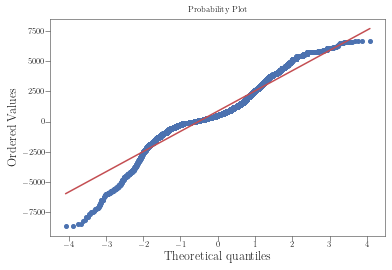

In [8]:
stats.probplot(df.n_days_after_certification, dist="norm", plot=plt)
plt.show()

In [3]:
df.head()

,cve,not_valid_before,not_valid_after,cve_published_date,n_days_after_certification,n_days_after_expiry
dgst,,,,,,
28819ed8f96586bc,CVE-2021-36169,2021-10-15,2026-10-15,2021-12-13,59,-1767
28819ed8f96586bc,CVE-2021-43206,2021-10-15,2026-10-15,2022-05-04,201,-1625
28819ed8f96586bc,CVE-2021-26108,2021-10-15,2026-10-15,2021-12-08,54,-1772
28819ed8f96586bc,CVE-2021-26092,2021-10-15,2026-10-15,2022-02-24,132,-1694
28819ed8f96586bc,CVE-2021-26103,2021-10-15,2026-10-15,2021-12-08,54,-1772


In [17]:
hist = sns.histplot(df.n_days_after_certification, kde=False)
hist.set(
    xlim=(-2200, 4600),
    ylim=(0,1800),
    xlabel="Number of days after date of certification",
    ylabel="Frequency of CVEs",
)
hist.axvline(0, color="red", linewidth="1", label="Certification date")
hist.legend(loc="upper right")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3.35, 2)
fig.savefig("/Users/adam/Downloads/cve_hist.pgf", bbox_inches="tight")
fig.savefig("/Users/adam/Downloads/cve_hist.pdf", bbox_inches="tight")
plt.close(fig)


## Top-10 CWES table rows

In [9]:
latex_table = pd.read_csv(RESULTS_DIR / "cwes/top_10_cwe_overall.csv").head(10).set_index("cwe_id")
name_mapping = {
    "Improper Restriction of Operations within the Bounds of a Memory Buffer": "Buffer overflow",
    "Exposure of Sensitive Information to an Unauthorized Actor": "Exposure of sensitive information",
    "Permissions, Privileges, and Access Controls": "Access control error",
    "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')": "Cross-site Scripting",
}
latex_table.cwe_name = latex_table.cwe_name.map(lambda x: name_mapping.get(x, x))

for index, row in latex_table.head(10).iterrows():
    print(f"{index} & {row['cwe_name']} & {row['frequency']} \\\\")


CWE-119 & Buffer overflow & 1817 \\
CWE-20 & Improper Input Validation & 1034 \\
CWE-200 & Exposure of sensitive information & 762 \\
CWE-264 & Access control error & 626 \\
CWE-79 & Cross-site Scripting & 536 \\
CWE-787 & Out-of-bounds Write & 438 \\
CWE-399 & Resource Management Errors & 365 \\
CWE-125 & Out-of-bounds Read & 355 \\
CWE-416 & Use After Free & 219 \\
CWE-284 & Improper Access Control & 178 \\


## Validity boxplot

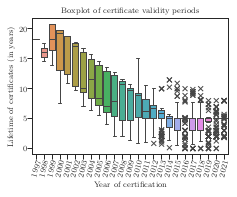

In [225]:
df_validity = pd.read_csv(RESULTS_DIR / "df_validity.csv")

box = sns.boxplot(data=df_validity, x="year_from", y="validity_period", linewidth=0.75, flierprops={"marker": "x"})
box.set(
    xlabel="Year of certification",
    ylabel="Lifetime of certificates (in years)",
    title="Boxplot of certificate validity periods",
)
box.tick_params(axis="x", rotation=75)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3.5, 2.5)
fig.savefig("/Users/adam/Downloads/boxplot_validity.pgf", bbox_inches="tight")
fig.savefig("/Users/adam/Downloads/boxplot_validity.pdf", bbox_inches="tight")


# Cells for 3-subplot figure

Contains: Average EAL levels, Interesting schemes evolution, Stackplot of categories

In [10]:
figure_width = 2.3
figure_height = 1.8

In [25]:
avg_levels = pd.read_csv(RESULTS_DIR / "avg_eal.csv")
eal_to_num_mapping = {eal: index for index, eal in enumerate(df["eal"].cat.categories)}
avg_levels["smartcard_category"] = avg_levels.category.map(
    lambda x: x if x == "ICs, Smartcards" else "Other 14 categories"
)
line = sns.lineplot(
    data=avg_levels.loc[avg_levels.year_from < 2022],
    x="year_from",
    y="eal_number",
    hue="smartcard_category",
    ci=None,
    style="smartcard_category",
    markers=True,
)
line.set(xlabel=None, ylabel=None, title=None, xlim=(1999.6,2021.4))
ymin = 1
ymax = 9
ylabels = [
    x if "+" in x else x + r"\phantom{+}" for x in list(eal_to_num_mapping.keys())[ymin : ymax + 1]
]  # this also aligns the labels by adding phantom spaces
line.set_yticks(range(ymin, ymax + 1), ylabels)
line.set_xticks([1997, 2002, 2007, 2012, 2017, 2021])
line.legend(title=None, labels=avg_levels.smartcard_category.unique())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(figure_width, figure_height)
fig.tight_layout(pad=0.1)
fig.savefig("/Users/adam/Downloads/temporal_trends_categories.pgf")
fig.savefig("/Users/adam/Downloads/temporal_trends_categories.pdf")
plt.close()

In [27]:
interesting_schemes = pd.read_csv(RESULTS_DIR / "interesting_schemes.csv")

line = sns.lineplot(
    data=interesting_schemes,
    x="year_from",
    y="size",
    hue="scheme",
    style="scheme",
    markers=True,
    dashes=True,
)
line.set(xlabel=None, ylabel=None, title=None, xlim=(1999.6,2021.4), ylim=(0, 60))
line.set_xticks([1997, 2002, 2007, 2012, 2017, 2021])
line.legend(title=None)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(figure_width, figure_height)
fig.tight_layout(pad=0.1)
fig.savefig("/Users/adam/Downloads/temporal_trends_schemes.pgf")
fig.savefig("/Users/adam/Downloads/temporal_trends_schemes.pdf")
plt.close()

In [19]:
n_certs = pd.read_csv(RESULTS_DIR / "popular_categories.csv").astype({"year_from": "category"})
dct = {
    "ICs, Smart Cards and Smart Card-Related Devices and Systems": "ICs, Smart Cards",
    "Network and Network-Related Devices and Systems": "Network-Related Devices",
    "Other Devices and Systems": "Other Devices",
    "One of 11 other categories": "11 Other Categories",
}
n_certs.popular_categories = n_certs.popular_categories.map(lambda x: dct.get(x, x))

cats = n_certs.popular_categories.unique()
years = n_certs.year_from.cat.categories[:-1]
data = [n_certs.loc[n_certs.popular_categories == c, "size"].tolist()[:-1] for c in cats]

palette = sns.color_palette("Spectral", 5).as_hex()
colors = ",".join(palette)

plt.stackplot(years, data, labels=cats, colors=colors)
plt.legend(loc="upper center", bbox_to_anchor=(0.38, 1.02))
plt.xticks([1997, 2002, 2007, 2012, 2017, 2021])
#plt.title("(c) Popularity of categories")
plt.xlim(1997, 2021)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(figure_width, figure_height)
fig.tight_layout(pad=0.1)
fig.savefig("/Users/adam/Downloads/temporal_trends_stackplot.pdf")
fig.savefig("/Users/adam/Downloads/temporal_trends_stackplot.pgf")
plt.close()

In [16]:
avg_levels.year_from.min()

1997.0